In [ ]:
# Step 1: Import Required Libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Enable memory growth for GPU (if running on GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [ ]:
import os
print(os.path.exists('/content/drive/MyDrive/archive/CamVid'))

True


In [ ]:
import os

camvid_path = '/content/drive/MyDrive/archive/CamVid'  # Adjust if needed

for subfolder in ['train', 'train_labels', 'val', 'val_labels', 'test', 'test_labels']:
    path = os.path.join(camvid_path, subfolder)
    files = os.listdir(path)
    print(f"{subfolder}: {len(files)} files")


train: 369 files
train_labels: 369 files
val: 100 files
val_labels: 100 files
test: 232 files
test_labels: 232 files


In [ ]:
import tensorflow as tf
import os

IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 32  # This will be updated based on the actual number in CamVid

# Path to the dataset
camvid_path = '/content/drive/MyDrive/archive/CamVid'


In [ ]:
def process_path(image_path, label_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]

    # Load the corresponding label mask
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)  # 1 channel = grayscale
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return image, label

In [ ]:
def get_dataset(image_dir, label_dir):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    label_paths = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


In [ ]:
train_dataset = get_dataset(
    os.path.join(camvid_path, 'train'),
    os.path.join(camvid_path, 'train_labels')
).batch(8).shuffle(100).prefetch(tf.data.AUTOTUNE)

val_dataset = get_dataset(
    os.path.join(camvid_path, 'val'),
    os.path.join(camvid_path, 'val_labels')
).batch(8).prefetch(tf.data.AUTOTUNE)

test_dataset = get_dataset(
    os.path.join(camvid_path, 'test'),
    os.path.join(camvid_path, 'test_labels')
).batch(8).prefetch(tf.data.AUTOTUNE)


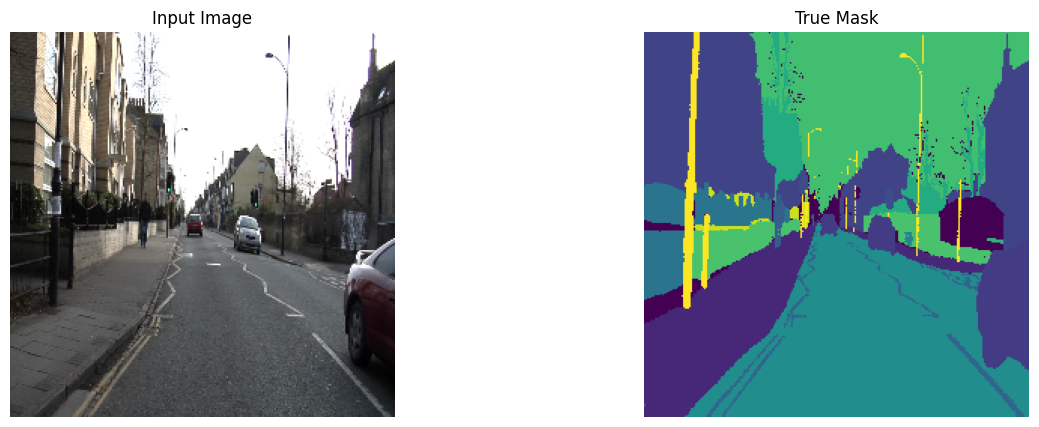

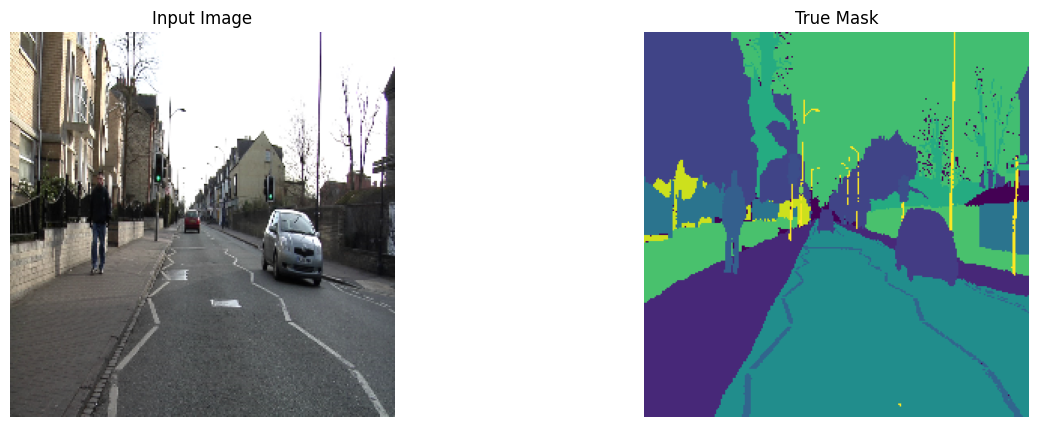

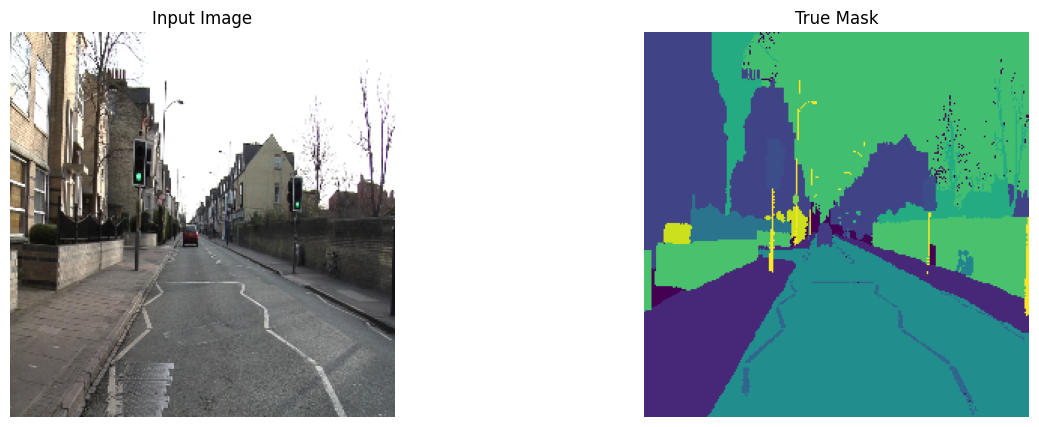

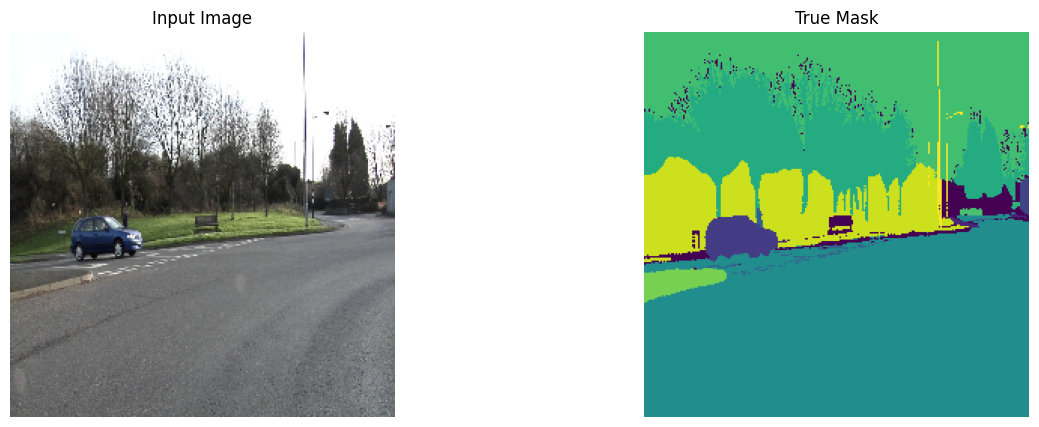

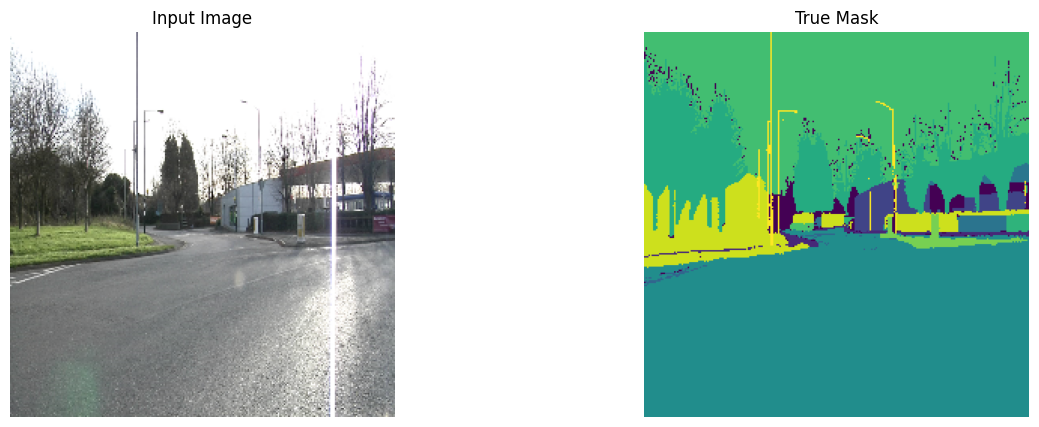

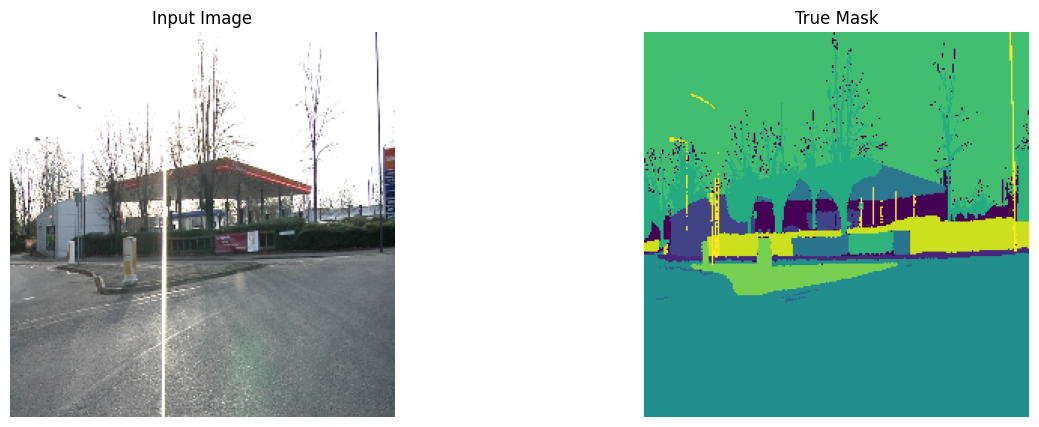

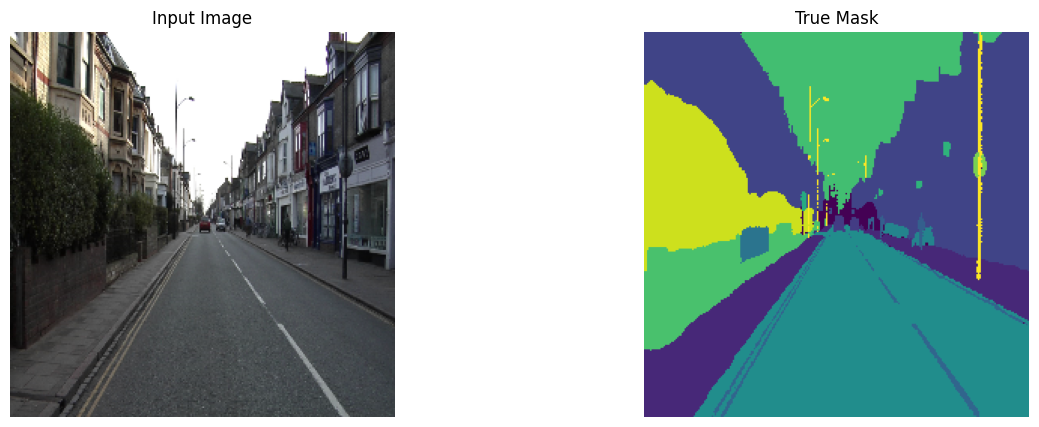

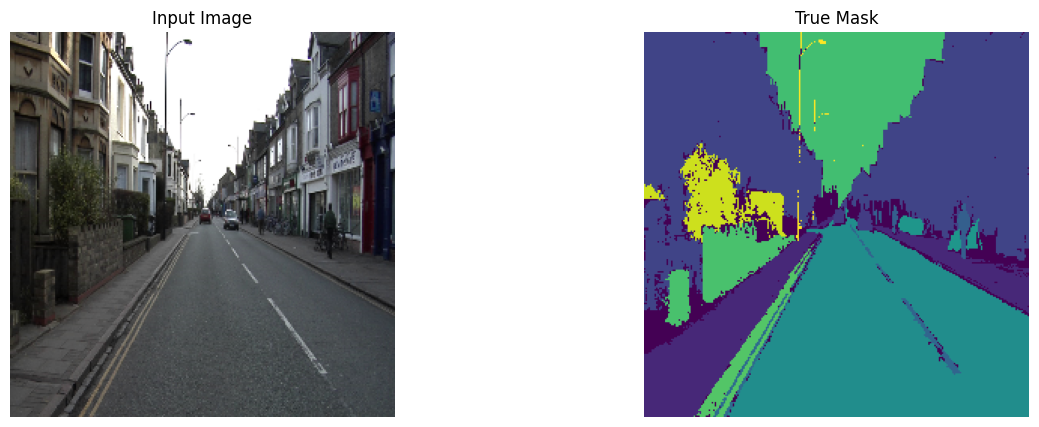

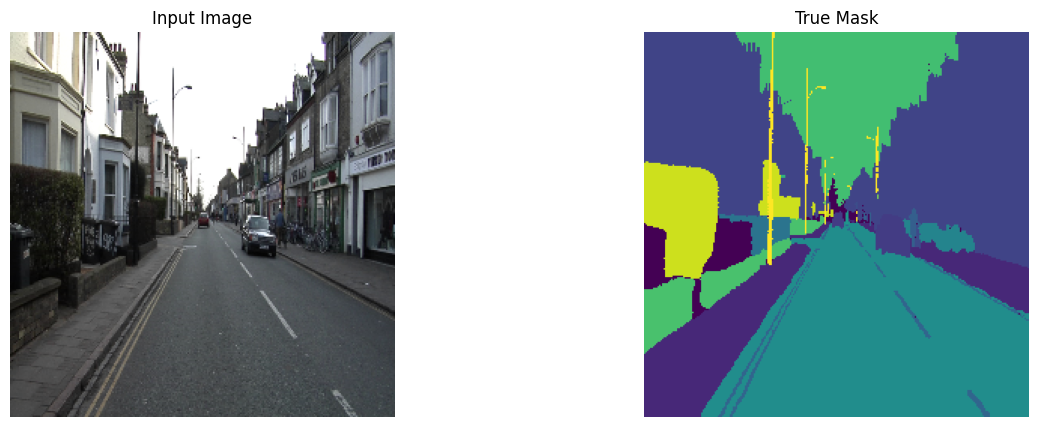

In [ ]:
import matplotlib.pyplot as plt

def display_sample(display_list):
    plt.figure(figsize=(15, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']  # Fixed title list

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.squeeze(display_list[i]))
        plt.axis('off')

    plt.show()

# Display 3 samples from the train dataset
for images, masks in train_dataset.take(3):
    for i in range(3):  # Show 3 examples per batch
        display_sample([images[i], masks[i]])


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(256, 256, 3), num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(input_size)

    # --- Encoder ---
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # --- Bottleneck ---
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # --- Decoder ---
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    # --- Output Layer ---
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model = unet_model(input_size=(256, 256, 3), num_classes=256)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
for image, mask in train_dataset.take(1):
    print(tf.reduce_max(mask))  # shows the highest label value


tf.Tensor(184, shape=(), dtype=uint8)


In [ ]:
# Callbacks for saving the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_128']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.1772 - loss: 6.4843

47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 705ms/step - accuracy: 0.1788 - loss: 6.4585 - val_accuracy: 0.3018 - val_loss: 2.4853
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.3421 - loss: 2.2865

47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 691ms/step - accuracy: 0.3427 - loss: 2.2835 - val_accuracy: 0.4326 - val_loss: 1.8675
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.4386 - loss: 1.9144

47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 570ms/step - accuracy: 0.4384 - loss: 1.9141 - val_accuracy: 0.5017 - val_loss: 1.7272
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 579ms/step - accuracy: 0.4831 - loss: 1.8082 - val_accuracy: 0.4887 - val_loss: 1.7966
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5539 - loss: 1.5963

47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 551ms/step - accuracy: 0.5546 - loss: 1.5950 - val_accuracy: 0.6184 - val_loss: 1.4559
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 44s 582ms/step - accuracy: 0.6072 - loss: 1.4410 - val_accuracy: 0.5436 - val_loss: 1.6768
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.5905 - loss: 1.4809

47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 646ms/step - accuracy: 0.5911 - loss: 1.4790 - val_accuracy: 0.6341 - val_loss: 1.3089
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6101 - loss: 1.3190

47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 617ms/step - accuracy: 0.6104 - loss: 1.3188 - val_accuracy: 0.6362 - val_loss: 1.2662
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6216 - loss: 1.2801

47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 579ms/step - accuracy: 0.6219 - loss: 1.2790 - val_accuracy: 0.6419 - val_loss: 1.2582
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - accuracy: 0.6519 - loss: 1.2019 - val_accuracy: 0.6229 - val_loss: 1.2977
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.6388 - loss: 1.2206

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 710ms/step - accuracy: 0.6386 - loss: 1.2208 - val_accuracy: 0.6519 - val_loss: 1.1531
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6553 - loss: 1.1640

47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 582ms/step - accuracy: 0.6552 - loss: 1.1638 - val_accuracy: 0.6522 - val_loss: 1.1420
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6715 - loss: 1.0675

47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 658ms/step - accuracy: 0.6712 - loss: 1.0685 - val_accuracy: 0.6154 - val_loss: 1.1278
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.6371 - loss: 1.1223

47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 719ms/step - accuracy: 0.6375 - loss: 1.1222 - val_accuracy: 0.6620 - val_loss: 1.1061
Epoch 15/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 530ms/step - accuracy: 0.6854 - loss: 1.0632 - val_accuracy: 0.6495 - val_loss: 1.1376
Epoch 16/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6585 - loss: 1.1118

47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 728ms/step - accuracy: 0.6585 - loss: 1.1118 - val_accuracy: 0.6700 - val_loss: 1.0634
Epoch 17/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 525ms/step - accuracy: 0.6892 - loss: 1.0337 - val_accuracy: 0.5949 - val_loss: 1.2079
Epoch 18/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6760 - loss: 1.1034

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 561ms/step - accuracy: 0.6761 - loss: 1.1029 - val_accuracy: 0.6754 - val_loss: 1.0274
Epoch 19/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 537ms/step - accuracy: 0.6827 - loss: 1.0179 - val_accuracy: 0.6744 - val_loss: 1.0910
Epoch 20/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 528ms/step - accuracy: 0.6713 - loss: 0.9984 - val_accuracy: 0.6912 - val_loss: 1.0290


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.6252 - loss: 1.2785
Test Loss: 1.1158, Test Accuracy: 0.6590


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_128']
Received: inputs=Tensor(shape=(8, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


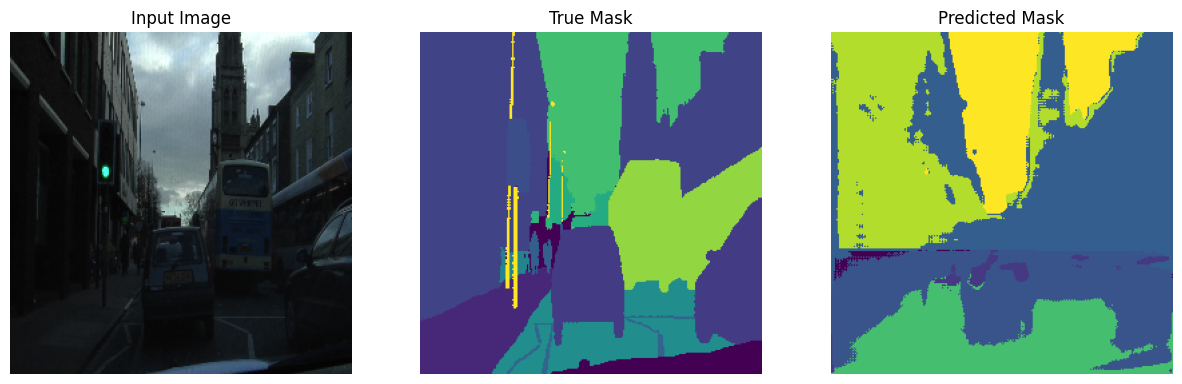

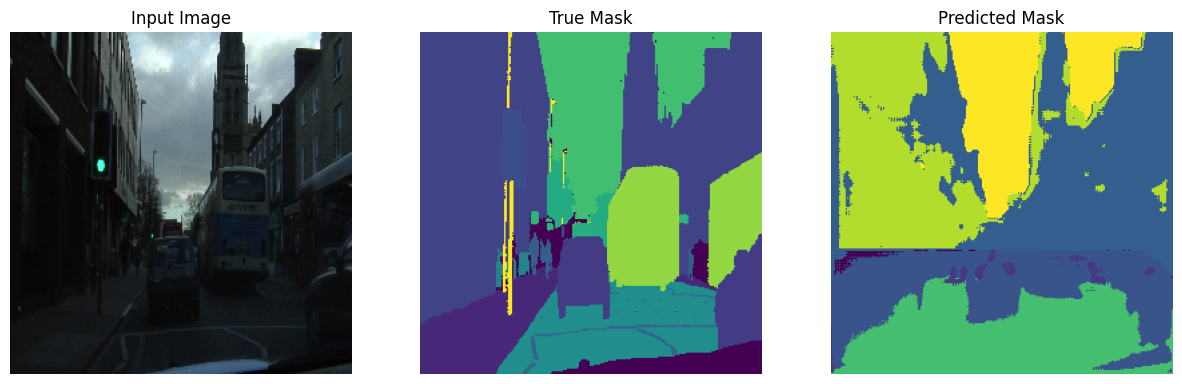

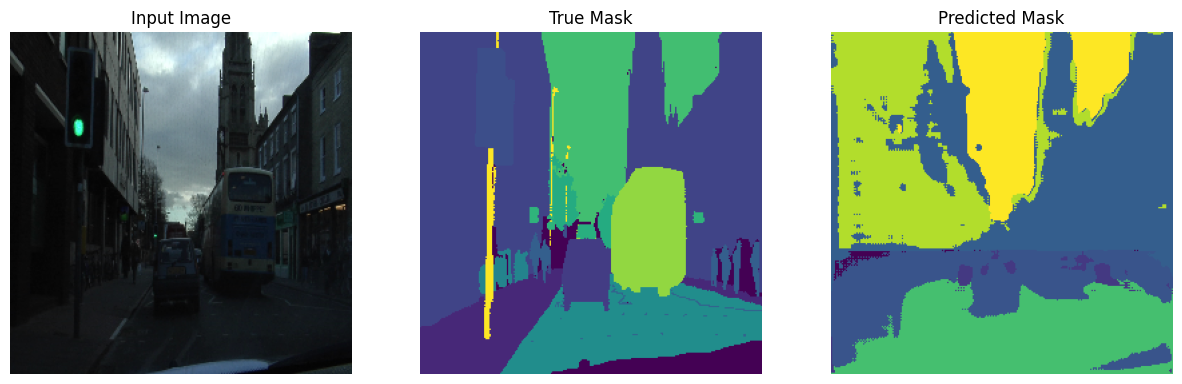

In [ ]:
def create_mask(pred_mask):
    return tf.argmax(pred_mask, axis=-1)

for images, masks in test_dataset.take(1):
    preds = model.predict(images)
    for i in range(3):  # Show 3 examples
        pred_mask = create_mask(preds[i])
        display_sample([images[i], masks[i], pred_mask])


In [ ]:
from tensorflow.keras.metrics import MeanIoU

# Calculate IoU
iou_metric = MeanIoU(num_classes=256)
for images, masks in test_dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1)
    preds = tf.expand_dims(preds, axis=-1)
    iou_metric.update_state(masks, preds)
print("Mean IoU:", iou_metric.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

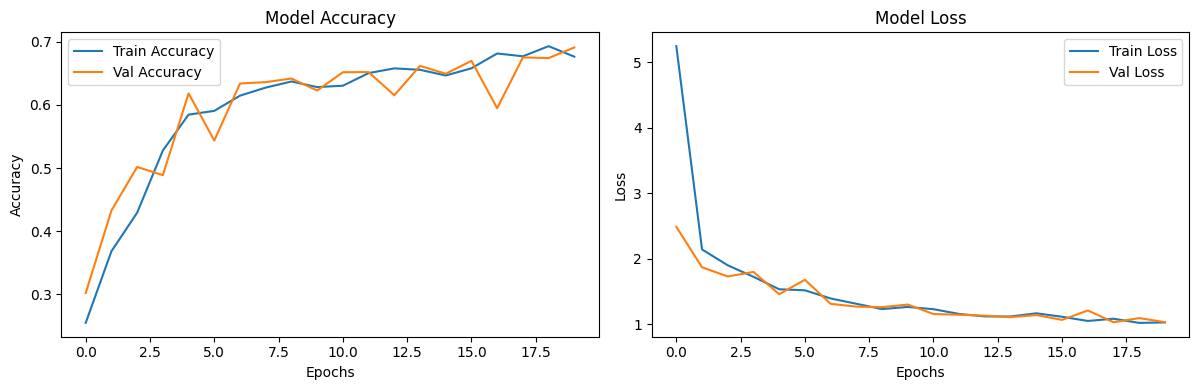

In [ ]:
plt.figure(figsize=(18, 4))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
